# A trivial example: Titanic dataset
**That scene**. What a tragedy.
But...

![drowning_scene](fig/drowning_scene.jpg "title-1")

...what if Jane had some machine learning to choose a better partner, more likely to survive in case of accident?

___

In [1]:
source('src/lib.R')

In [2]:
# import the data
titanic_df = read_csv('data/titanic.csv', col_types = cols())

## Let's have a look at the data
Randomly choosing a partner aged 18 - 40 is **not a good idea, Rose...**

For the record, the fields in the dataset are the following:

| Variable | Definition  | | Key |
|------|------|------|------|
| $\texttt{survival}$ | Survival || 0 = No, 1 = Yes |
| $\texttt{pclass}$  | Ticket Class || 1 = 1st, 2 = 2nd, 3 = 3rd |
| $\texttt{sex}$ | Sex | | |
| $\texttt{age}$ | Age in years | | |
| $\texttt{sibsp}$ | # of siblings / spouses aboard the Titanic | | |
| $\texttt{parch}$ | # of parents / children aboard the Titanic | | |
| $\texttt{ticket}$ | Ticket number | | |
| $\texttt{fare}$ | Passenger fare | | |
| $\texttt{cabin}$ | Cabin number | | |
| $\texttt{embarked}$ | Port of Embarcation | |C = Cherbourg, Q = Queenstown, S = Southampton |

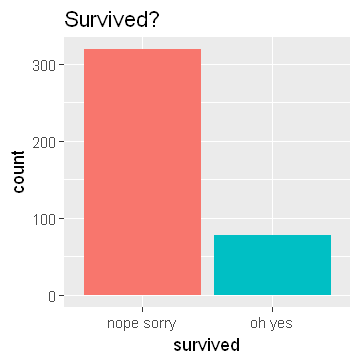

In [3]:
options(repr.plot.width=3, repr.plot.height=3) # reduce plot size

titanic_df %>% filter(sex == 'male', age > 18, age < 40) %>% 
  select(survived) %>% mutate(survived = ifelse(survived == 1, 'oh yes', 'nope sorry')) %>% 
  ggplot(aes(survived, fill = survived)) + geom_bar() + ggtitle('Survived?') + theme(legend.position = "none")

options(repr.plot.width=6, repr.plot.height=5) # back to the normal plot size

...indeed, approximately 3 every 4 will likely die in case of accident.

In [4]:
titanic_df %>% select(
    survived, # select features
    pclass,
    sex,
    age,
    sibsp,
    parch,
    fare,
    cabin,
    embarked) %>% head

survived,pclass,sex,age,sibsp,parch,fare,cabin,embarked
1,1,female,29.0000,0,0,211.3375,B5,S
1,1,male,0.9167,1,2,151.5500,C22 C26,S
0,1,female,2.0000,1,2,151.5500,C22 C26,S
0,1,male,30.0000,1,2,151.5500,C22 C26,S
0,1,female,25.0000,1,2,151.5500,C22 C26,S
1,1,male,48.0000,0,0,26.5500,E12,S


___

## Pre-processing

#### Partition the data
Let's partition the dataset in two subsample. Just know that this is a common procedure to avoid overfitting and be able to assess the goodness of the model in a non-biased way. We'll discuss more in depth about this next time!

In [5]:
set.seed(123) # set seed for reproducibility of createDataPartition

partition = titanic_df %>% nrow %>% seq_len %>% createDataPartition(times = 1, p = 0.7, list = F)

train_raw = titanic_df %>% slice(partition)
test_raw = titanic_df %>% slice(-partition)

cat('train data size\n')
train_raw %>% dim

cat('test data size\n')
test_raw %>% dim

train data size


[1] 918  14

test data size


[1] 392  14

#### Prepare the data for being fed into the model

* convert data types to float / integer
* define rule for managing missing values (*NA*s)
* you could even normalize the features (we are not doing this here)

In [6]:
data_processing = function(df){
  df %>%
    select(survived, # select features
           pclass,
           sex,
           age,
           sibsp,
           parch,
           fare,
           cabin,
           embarked
    ) %>% 
    mutate_if(is.character, fct_explicit_na) %>% # assign levels to missings
    mutate_all(as.numeric) %>% mutate_all(funs(replace(., is.na(.), 0))) # %>% # set missings to 0
    # mutate_all(scale) # normalize data
}

train = data_processing(train_raw)
test = data_processing(test_raw)


# save datasets
write_csv(train, 'data/titanic_train.csv')
write_csv(test, 'data/titanic_test.csv')

In [7]:
train %>% glimpse

Observations: 918
Variables: 9
$ survived <dbl> 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0...
$ pclass   <dbl> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1...
$ sex      <dbl> 1, 2, 2, 2, 1, 1, 2, 1, 2, 2, 1, 2, 1, 1, 2, 2, 2, 1, 1, 2...
$ age      <dbl> 29.0000, 0.9167, 48.0000, 39.0000, 24.0000, 26.0000, 80.00...
$ sibsp    <dbl> 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0...
$ parch    <dbl> 0, 2, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0...
$ fare     <dbl> 211.3375, 151.5500, 26.5500, 0.0000, 69.3000, 78.8500, 30....
$ cabin    <dbl> 36, 64, 120, 13, 27, 149, 6, 99, 78, 110, 110, 149, 35, 95...
$ embarked <dbl> 3, 3, 3, 3, 1, 3, 3, 1, 1, 3, 3, 1, 1, 3, 3, 3, 1, 3, 3, 3...


___
## Fit a KNN model and make some predictions

In [9]:
# fit knn

model = train(x = train %>% select(-one_of('survived')),
              y = train %>% select(one_of('survived')) %>% pull %>% factor,
              method = 'kknn',
              tuneGrid = data.frame(kmax = 20,
                                    kernel = c("triangular"),
                                    distance = 0.5),
              trControl = trainControl(method = 'none')
)

# save model

saveRDS(model, 'data/titanic_model.R')

train %>% select(one_of('survived')) %>% pull %>% factor

[1] 1 1 1 0 1 1 1 1 0 1 1 0 1 1 1 0 1 1 1 0 1 1 1 0 0 0 1 1 1 1 0 1 1 0 1 1 0
 [38] 1 0 1 0 1 1 1 1 1 1 1 1 1 0 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0
 [75] 1 1 1 0 1 0 0 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 0 1 1 0 1 0 1
[112] 0 1 1 0 1 0 0 1 1 0 1 1 1 1 0 1 1 1 1 1 1 0 1 1 0 1 1 0 1 0 1 0 1 1 1 0 1
[149] 0 0 1 1 0 0 0 0 1 0 1 1 0 0 0 0 1 0 1 0 0 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 0
[186] 1 1 1 1 1 0 1 0 1 1 0 1 0 0 1 0 1 1 0 1 1 1 1 0 0 1 0 1 0 0 0 1 1 0 1 0 0
[223] 1 0 1 1 0 0 1 0 1 0 0 1 0 0 1 1 1 1 1 1 1 0 0 0 0 1 1 1 0 1 0 1 1 1 0 0 0
[260] 0 0 0 1 1 0 0 1 1 0 0 0 0 1 0 1 1 0 0 1 0 0 1 1 0 1 0 1 1 0 0 0 0 1 0 0 0
[297] 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0 1 1 1 1 0 1 0 1 0 0 1 1 0 0 0 1 0 0 1 0 1 0
[334] 1 0 0 0 1 1 1 1 0 0 0 0 0 1 0 1 0 0 0 1 1 1 0 0 0 0 0 0 1 1 1 0 0 1 1 1 0
[371] 0 1 0 0 1 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 0 0 1 1 1 0 0 0 0 1 1 1 0 0 1 1 1
[408] 0 1 1 1 1 1 0 1 0 0 1 1 0 0 0 1 1 1 1 0 1 1 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0
[445] 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 1 1 1 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
[482] 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0
[519] 0 1 0 0 1 1 0 0 0 0 0 0 1 1 1 0 1 1 0 0 0 0 0 1 0 0 0 0 0 1 1 1 0 1 1 0 0
[556] 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0
[593] 0 0 0 1 0 0 0 0 0 0 0 1 1 1 0 1 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 1 1 0 0 1 0
[630] 1 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 1 1 0 0 1 0 0 0 0 0 1 0 0 0 0 0
[667] 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 1 0 1 0 0 0 1
[704] 1 1 1 1 1 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 1 1 1 0 1 0 1 1 1 0 0 1 1
[741] 1 0 0 0 1 1 1 1 0 0 1 0 1 0 0 0 1 0 0 0 0 1 1 1 1 0 0 0 0 1 0 0 0 1 0 0 0
[778] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
[815] 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 1 1 0 0 0 0 0 1 1 0 0
[852] 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 1 1 1
[889] 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0 0
Levels: 0 1

In [25]:
test_response = model %>%
  predict(newdata = test %>% select(-one_of('survived'))) %>% factor

In [26]:
# show predictions for male, aged 18-40

(pred = test_raw %>% bind_cols(data_frame('guess_survived' = test_response)) %>%
  filter(sex == 'male',age > 18, age < 40) %>%
  select(name, sex, age, guess_survived, survived)) %>% head

name,sex,age,guess_survived,survived
"Allison, Mr. Hudson Joshua Creighton",male,30,1,0
"Baxter, Mr. Quigg Edmond",male,24,0,0
"Behr, Mr. Karl Howell",male,26,1,1
"Bishop, Mr. Dickinson H",male,25,1,1
"Carlsson, Mr. Frans Olof",male,33,0,0
"Carrau, Mr. Francisco M",male,28,1,0


In [27]:
# how good is the model for this subclass?
acc = confusionMatrix(pred$guess_survived, pred$survived %>% factor)
acc$overall[1] %>% round(3)

Accuracy 
   0.815

hey, it seems that now Rose has around 80% chanche of getting the right partner! Awsome!


## Well, probably not. But why?

Stay tuned...